<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/Rectifier_12PulseTransformerCurrent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Currents Flowing through the 12-Pulse Transformer</h1></b>

Dr. Bingsen Wang

3/31/2024
</center>

#Delta Winding Currents

For the delta winding currents, the following equations hold
$$\begin{align}
i_{ba2} - i_{ac2} &= i_{a2}\tag{1}\\
i_{cb2} - i_{ba2} &= i_{b2}\tag{2}
\end{align}
$$

Since there is no circulation current inside the delta winding, then we have
$$i_{ba2} + i_{cb2} + i_{ac2} =0\tag{3}$$

Adding equations (1) and (3) yields
$$2i_{ba2} +  i_{cb2} = i_{a2}\tag{4}$$

Substituting (4) into (2) yields
$$i_{ba2} = \frac{i_{a2} - i_{b2}}{3}\tag{5}$$
Then it follows that
$$i_{cb2} = \frac{i_{b2} - i_{c2}}{3}\\
i_{ac2} = \frac{i_{c2} - i_{a2}}{3}\tag{6}$$

#Python Code
The Python code illustrates waveforms of the 12-pulse transformer.

<ipython-input-48-f5f89b8b3a1c>:265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


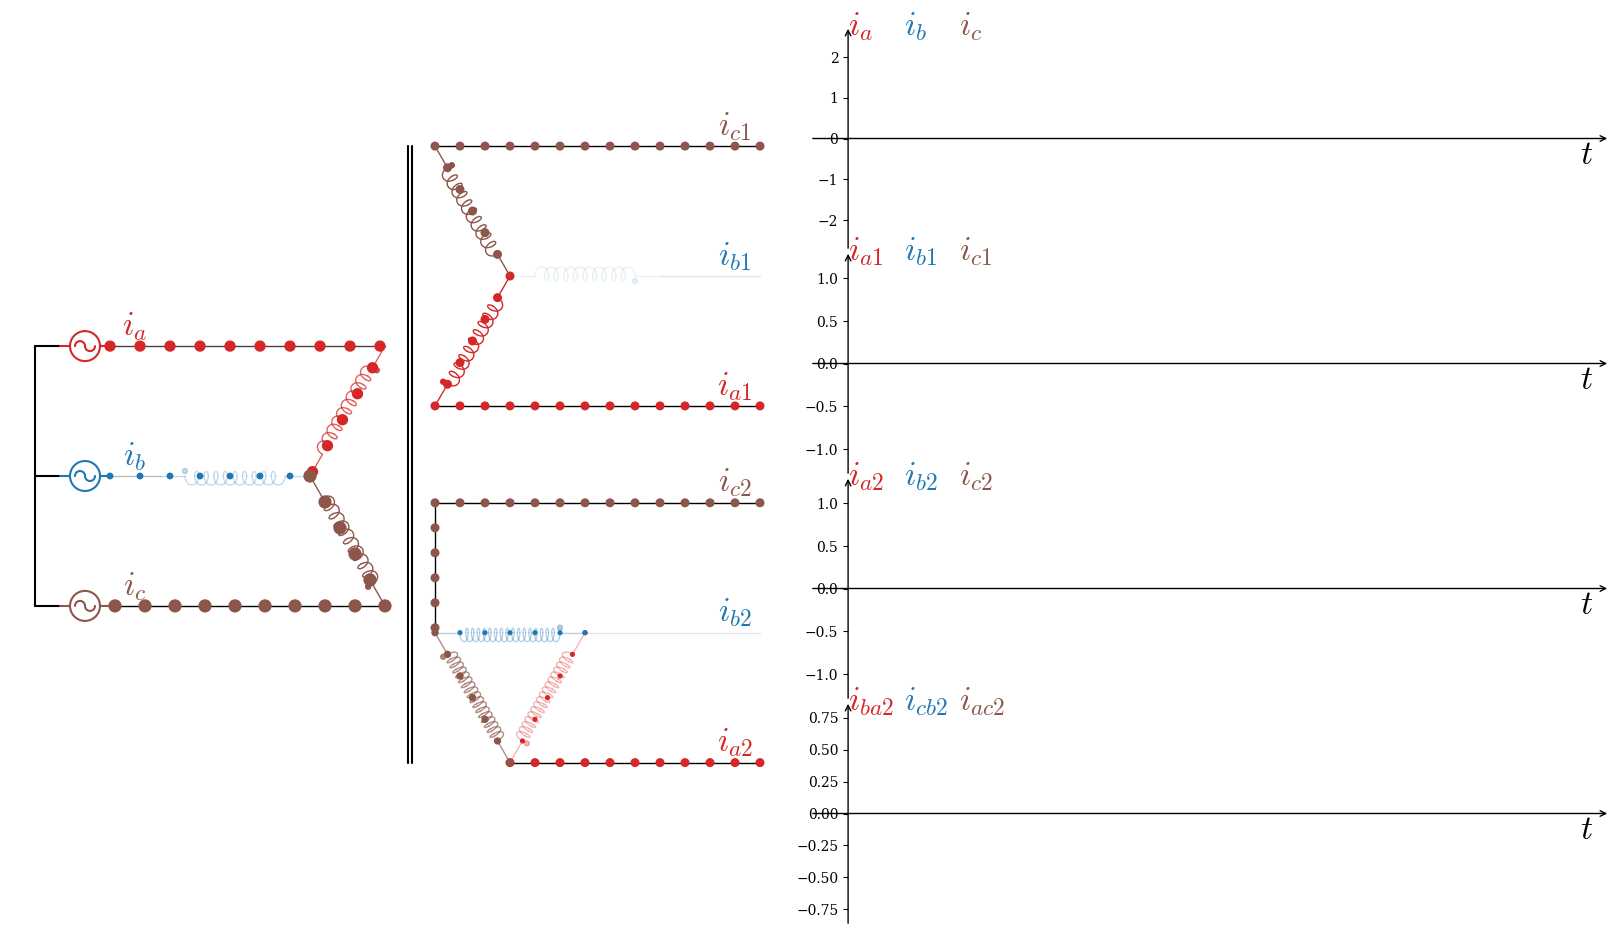

In [48]:
import matplotlib
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,heaviside,array,sqrt,angle,exp,sign
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex, to_rgb
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#modulation functions
def mf(t,f,phi):
  mt = []
  for k in range(3):
    mt.append(cos(2*pi*f*t+phi - k*2*pi/3))
  return mt

#switching functions for the high-side diodes
def hh(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+1)%3],0)*heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+2)%3],0))
  return ht

#switching functions for the low-side diodes
def hl(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+1)%3],0)*heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+2)%3],0))
  return ht

#ac current
def iac(t,f,phi):
  i = [] #high side current
  for k in range(3):
    i.append(hh(t,f,phi)[k] - hl(t,f,phi)[k])
  return i


#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,w,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  w= w/(0.7*n+0.3)#width of larger coil
  plg, psm = ([],[]) #the half coil with larger curvature
  codes=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)]
  for k in range(n):
    if k==0:
      plg.append(mp.PathPatch(Path(verts,codes)))
    else:
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),
                (x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)], codes)
      plg.append(mp.PathPatch(p))
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),
                (x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)], codes)
      psm.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw transformer winding
def drawTransformerWinding(ax,x0,y0,n,h,w,theta,lw,color,dotpos='start'):
  codes = [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  drawInductor(ax,x0+w/6*cos(theta*pi/180),y0+w/6*sin(theta*pi/180),n,h,w*2/3,theta,lw,color)
  p = Path([(x0,y0), (x0+w/6,y0), (x0+5/6*w,y0), (x0+w,y0)], codes)
  rdot = h/12 #dot radius
  if dotpos == 'start':
    dot = mp.Circle((x0+w/6,y0-2*rdot),rdot)
  else:
    dot = mp.Circle((x0+w*5/6,y0-2*rdot),rdot)
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc = PatchCollection([mp.PathPatch(p),dot],ec=color,fc=color,lw=lw,transform=rot)
  ax.add_collection(pc)

  return

#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[] # container of the zig-zags
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return



#moving dots for current flow, only works for any lines
def drawMovingDots(ax,path,space,n_steps,nth_step,rdot,color):
  for k in range(len(path)-1):
    pk = path[k][0] +1j*path[k][1] #complex number of point k
    pk1 = path[k+1][0] +1j*path[k+1][1] #complex number of point k+1
    dp = pk1-pk
    theta = angle(dp)
    if k==0:
      lst = space*nth_step/n_steps# distance of starting point
    for kk in range(int((abs(dp)-lst)/space)+1):
      ax.add_patch(mp.Circle([(pk+(lst+kk*space)*exp(1j*theta)).real,
       (pk+(lst+kk*space)*exp(1j*theta)).imag],radius=rdot,fc=color))
    lst = space - (abs(dp)-lst)%space #update the distance of starting point
  return

#draw non-animated parts of the circuitry
def drawRectifierNa(ax,lw,clst,txlst):
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None'})
  args1=  dict({'size':24,'va':'center'})
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  x=2
  y=4.5
  x0 = x+1 #center for primary 3-ph winding
  y0 = y #center for primary 3-ph winding
  x1 = x+3 #center for secondary 3-ph wye winding
  y1 = 6.5 #center for secondary 3-ph wye winding
  x2 = x1 #center for secondary 3-ph delta winding
  y2 = 2.5 #center for secondary 3-ph delta winding
  for k in range(3):
    p1 = Path([(x-1.75,y0+(1-k)*sqrt(3)/2*1.5),(x-1.5,y0+(1-k)*sqrt(3)/2*1.5)], codes[0:2])
    ax.add_patch(mp.PathPatch(p1,**args))
    drawVoltSourceAc(ax,x-1.5,y+(1-k)*sqrt(3)/2*1.5,.5,0,lw,clst[k])
    ax.text(x0-1.75,y0+.2+1.5*sqrt(3)/2*(1-k),txlst[0][0][k],color=clst[k],ha='center',**args1) #iabc
    ax.text(x1+2.25,y1+.2+1.5*sqrt(3)/2*(k-1),txlst[1][0][k],color=clst[k],ha='center',**args1) #iabc1
    ax.text(x2+2.25,y2+.2+1.5*sqrt(3)/2*(k-2/3),txlst[2][0][k],color=clst[k],ha='center',**args1) #iabc2
  p2 = Path([(x-1.75,y+1.5*sqrt(3)/2), (x-1.75,y-1.5*sqrt(3)/2)], codes[0:2]) #source neutral vertical
  p3 = Path([((x0+x1)*.5-.02,y1+1.5*sqrt(3)/2), ((x0+x1)*.5-.02,y2-sqrt(3)/2),
             ((x0+x1)*.5+.02,y1+1.5*sqrt(3)/2), ((x0+x1)*.5+.02,y2-sqrt(3)/2)], codes) #core
  ax.add_patch(mp.PathPatch(p2,**args))
  ax.add_patch(mp.PathPatch(p3,**args))
  # drawInductor(ax,x+9,2.5,5,.75,1,0,lw,'k') #dc inductor
  # ax.text(x+8,0,txlst[0][0],color=clst[0],ha='center',**args1) #vdc
  return

#draw animated parts of the circuitry
def drawRectifierAnim(ax,i_ani,ip,isy,isd,isdph,lw,clst):
  x=2
  y=4.5
  x0 = x+1 #center for primary 3-ph winding
  y0 = y #center for primary 3-ph winding
  x1 = x+3 #center for secondary 3-ph wye winding
  y1 = 6.5 #center for secondary 3-ph wye winding
  x2 = x1 #center for secondary 3-ph delta winding
  y2 = 2.5 #center for secondary 3-ph delta winding
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None'})
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  for k in range(3):
    drawTransformerWinding(ax,x0,y0,10,0.3,1.5,60+k*120,lw,
                           to_rgba(clst[k],max(abs(ip[k])/2.16,0.1)),dotpos='end') #primary
    drawTransformerWinding(ax,x1,y1,10,0.3,1.5,240+k*120,lw,to_rgba(clst[k],max(abs(isy[k]),0.1)),dotpos='end') #2nd y
    drawTransformerWinding(ax,x2+sqrt(3)/2*cos(-pi/2+k*2*pi/3),
                           y2+sqrt(3)/2*sin(-pi/2+k*2*pi/3),
                           17,0.3,1.5,60+k*120,lw,to_rgba(clst[k],max(abs(isdph[k]),0.1)),dotpos='start') #2nd delta
    points_prim = [(x-1,y0+(1-k)*sqrt(3)/2*1.5),
     (x0+1.5*cos(pi/3+k*2*pi/3),y0+(1-k)*sqrt(3)/2*1.5)]
    p1 = Path(points_prim, codes[0:2]) #primary
    points_sy = [(x1+2.5,y1+1.5*sin(4*pi/3 + k*2*pi/3)),
     (x1+1.5*cos(4*pi/3 + k*2*pi/3),y1+1.5*sin(4*pi/3 + k*2*pi/3))]
    p2 = Path(points_sy,codes[0:2]) #2nd wye
    if k==2:
      points_sd = [(x2+sqrt(3)/2*cos(-pi/2 + k*2*pi/3),y2+sqrt(3)/2*sin(-pi/2 + k*2*pi/3)),
                 (x2+sqrt(3)/2*cos(-pi/2 + k*2*pi/3),y2+sqrt(3)/2*sin(-pi/2 + k*2*pi/3)+1.5*sqrt(3)/2),
               (x2+2.5,y2+sqrt(3)/2*sin(-pi/2 + k*2*pi/3)+1.5*sqrt(3)/2)]
      p3 = Path(points_sd,codes[0:2]+[codes[-1]])
    else:
      points_sd = [(x2+sqrt(3)/2*cos(-pi/2 + k*2*pi/3),y2+sqrt(3)/2*sin(-pi/2 + k*2*pi/3)),
                 (x2+2.5,y2+sqrt(3)/2*sin(-pi/2 + k*2*pi/3))]
      p3 = Path(points_sd,codes[0:2]) #2nd delta
    ax.add_patch(mp.PathPatch(p1,color=to_rgba('k',max(abs(ip[k])/2.16,0.1)),**args))
    ax.add_patch(mp.PathPatch(p2,color=to_rgba('k',max(abs(isy[k]),0.1)),**args))
    ax.add_patch(mp.PathPatch(p3,color=to_rgba('k',max(abs(isd[k]),0.1)),**args))
    points_prim.append((x0,y0)) #primary moving dots path
    drawMovingDots(ax,points_prim[::int(sign(ip[k]))],0.3,16,i_ani%16,.045*sqrt(abs(ip[k])),clst[k])
    points_sy.append((x1,y1)) #secondary wye, moving dots path
    if sign(isy[k])!=0:
      drawMovingDots(ax,points_sy[::int(-sign(isy[k]))],0.25,16,i_ani%16,.045*sqrt(abs(isy[k])),clst[k])
    if sign(isd[k])!=0:
      drawMovingDots(ax,points_sd[::int(sign(isd[k]))],0.25,16,i_ani%16,.045*sqrt(abs(isd[k])),clst[k])
    points_sdph = [(x2+sqrt(3)/2*cos(-pi/2 + (k+1)*2*pi/3),y2+sqrt(3)/2*sin(-pi/2 + (k+1)*2*pi/3)),
                   (x2+sqrt(3)/2*cos(-pi/2 + k*2*pi/3),y2+sqrt(3)/2*sin(-pi/2 + k*2*pi/3))]
    drawMovingDots(ax,points_sdph[::int(sign(isdph[k]))],0.25,16,i_ani%16,.045*sqrt(abs(isdph[k])),clst[k])

  return

#parameters
f=1
Nf = 500
t=linspace(0,1,Nf)
tmax = max(t)
phi = 30*pi/180
mt = mf(t,f,phi) #time domain modulation functions
iabc1 = iac(t,f,phi) #currents of 2nd wye winding
iabc2 = iac(t,f,phi-pi/6) #currents line 2nd delta winding line currents
ibacbac2 = [(iabc2[0]-iabc2[1])/3, (iabc2[1]- iabc2[2])/3, (iabc2[2] - iabc2[0])/3]
iabc = [iabc1[0]+ibacbac2[0]*sqrt(3),
        iabc1[1]+ibacbac2[1]*sqrt(3),iabc1[2]+ibacbac2[2]*sqrt(3)] #primary
#set up figures
fig = plt.figure(figsize=(16,9)) #overall plot area
km = 1.1 # margin
ax_frame = [[(0, 0, .5, 1),[0,8],[0,9]], #circuit diagram
            [(0, 0, .5, 1),[0,8],[0,9]], #animated circuit
            [(.5, .75, .5, .25), [-.05*km,1*km],[-2.5*km,2.5*km]], #iabc
            [(.5,  .5, .5, .25), [-.05*km,1*km],[-1.2*km,1.2*km]], #iabc1
            [(.5, .25, .5, .25), [-.05*km,1*km],[-1.2*km,1.2*km]], #iabc2
            [(.5,  0,  .5, .25), [-.05*km,1*km],[-.8*km,.8*km]], #iab,bc,ca2
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lst=[] #axis list or the list of subplots
ax_lbl=[
        [['$i_{a}$', '$i_{b}$', '$i_{c}$'],  '$t$'],
        [['$i_{a1}$','$i_{b1}$','$i_{c1}$'], '$t$'],
        [['$i_{a2}$','$i_{b2}$','$i_{c2}$'], '$t$'],
        [['$i_{ba2}$','$i_{cb2}$','$i_{ac2}$'], '$t$'],
        ] #variables for yx axes of each subplot
clst=['tab:red','tab:blue','tab:brown','tab:purple'] #list of colors used for plots
text_tls = [] #place holder for titles of each plot updated during animation

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
for k in range(len(ax_frame)):
  ax=fig.add_axes(ax_frame[k][0],xlim=ax_frame[k][1], ylim=ax_frame[k][2],
                  fc='none') #remove frame face color
  if k<2:
    ax.axis('off') #turn the first 2 axes for circuit digram completely off
  else: #the rest axes
    ax.spines[:].set_visible(False) #set all spines off
    ax.spines['left'].set_position(('data', 0)) #set spines to cross zero
    ax.set_xticks([]) #set x-axis ticks off
    xmin,xmax,ymin,ymax=np.concatenate((ax_frame[k][1],ax_frame[k][2]))
    ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin),
          arrowprops=dict(arrowstyle="->")) #draw y-axis with arrow
    ax.text(xmax-0.025,0,ax_lbl[k-2][-1],
            size=24,va='top',ha='right',color='k') #label x axis of subplot
    for kk in range(len(ax_lbl[k-2][0])):
      ax.text(kk*0.08,ymax,ax_lbl[k-2][0][kk],size=24,va='center',color=clst[kk])
      lines.append(ax.plot([],[],color=clst[kk],lw=2)[0])
  ax_lst.append(ax)
fig.tight_layout()


# animation function. This is called sequentially
def animate(i):
  print(i) #for monitoring
  # i = 34
  for k in range(3):
    lines[k].set_data(t[0:i]/tmax,iabc[k][0:i])
    lines[3+k].set_data(t[0:i]/tmax,iabc1[k][0:i])
    lines[6+k].set_data(t[0:i]/tmax,iabc2[k][0:i])
    lines[9+k].set_data(t[0:i]/tmax,ibacbac2[k][0:i])

  ax_lst[1].clear()
  ax_lst[1].set_xlim(ax_frame[1][1])
  ax_lst[1].set_ylim(ax_frame[1][2])
  ax_lst[1].axis('off')
  drawRectifierAnim(ax_lst[1],i,array(iabc)[:,i],array(iabc1)[:,i],
                    array(iabc2)[:,i],array(ibacbac2)[:,i],1,clst)
  return

drawRectifierNa(ax_lst[0],1.5,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
writervideo = animation.FFMpegWriter(fps=20)
anim.save('rectifier_12PulseTransformer.mp4', writer=writervideo,dpi = 240)